In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
from fastai.datasets import datapath4file
import pandas as pd

In [3]:
path = datapath4file('/home/nbuser/courses/fast-ai/course-v3/nbs/data/toxic')
path.mkdir(parents=True, exist_ok=True)
#path

In [4]:
#! kaggle competitions download -c jigsaw-toxic-comment-classification-challenge -p {path}

In [5]:
df = pd.read_csv(path/'train.csv', nrows = 1000)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
data_lm = (TextList.from_df(df, cols='comment_text')
           #Where are the inputs? Column 'text' of this csv
                   .random_split_by_pct()
           #How to split it? Randomly with the default 20%
                   .label_for_lm()
           #Label it for a language model
                   .databunch())

In [7]:
data_lm.show_batch()

idx,text
0,"background xxunk i 'm xxunk stuck with . xxmaj thanks . ( talk ) xxunk , xxmaj january 11 , xxunk ( xxup utc ) xxbos xxmaj hey man , i 'm really not trying to edit war . xxmaj it 's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page . xxmaj he seems to care more about"
1,"xxmaj now , the edit itself is relevant - this is probably the single most xxunk about event xxunk he news as of late . xxmaj his xxunk is notable , since he is the only living xxunk - president who did not xxunk . xxmaj that 's certainly more notable than his xxunk an xxunk xxunk . \n i intend to revert this edit , in xxunk of"
2,"ignored the xxup xxunk position , which is exactly what the quote says and also something xxunk xxunk with . \n \n xxmaj again , i was xxunk the notion that it was a "" "" absurd part "" "" to claim that xxunk is a xxunk xxunk . xxmaj since many researchers xxunk this position , it would be xxunk to call it absurd . xxmaj the xxunk"
3,"is still perfectly valid . xxmaj if you know you are telling the truth , you will argue with xxunk or xxunk . xxmaj also part of xxmaj xxunk 's research was a xxunk of the xxunk story where possible to verify if any were false xxunk . xxmaj in all xxunk the xxunk version of events xxunk what the accused said happened . \n \n xxmaj arguing that"
4,"xxmaj apparently works of the xxmaj xxunk government are usually public domain , but we do n't have a similar article on xxmaj xxunk , so i guess i 'll have to research the old - xxunk , non - lazy , actually reliable way . xxmaj or ask the copyright help xxunk , like you suggested . xxmaj in the xxunk , i 'm using the fair use rationale"


In [24]:
data_clas = (TextList.from_df(df, cols='comment_text',vocab=data_lm.vocab)
                   .random_split_by_pct()
                   .label_from_df(cols=['toxic','severe_toxic','obscene','threat','insult','identity_hate'])
                   .databunch())

In [9]:
data_clas.show_batch()

In [10]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.92E-02


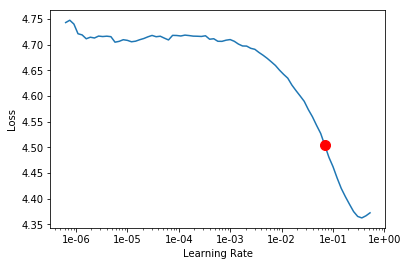

In [12]:
learn.recorder.plot(skip_end=15)

In [15]:
learn.fit_one_cycle(1, 21e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.692816,4.158260,0.253080


In [16]:
learn.save('fit_head')

In [19]:
TEXT = "I don't really like this edit"
N_WORDS = 40
N_SENTENCES = 2

In [20]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I don't really like this edit , or when i am western , and David Wales , who is brought forms to Wikipedia , who 's who she was a new - Bad , who was not the prime of the
I don't really like this edit to be 
 
  The himself The People would use the French the following . . If you have asked any time , To review them . 
  For any reason , you


In [22]:
learn.save_encoder('untuned_encoder')

In [25]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('untuned_encoder')

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-02


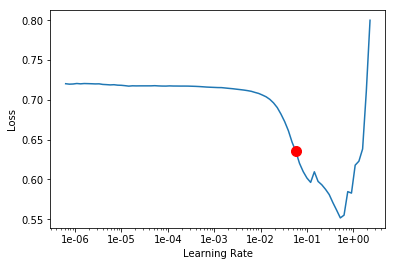

In [27]:
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(1, 7e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss
1,0.255607,0.135621


In [31]:
learn.predict("Please don't add non sense to the site. Such edits are considered vandalism")

(MultiCategory ,
 tensor([0., 0., 0., 0., 0., 0.]),
 tensor([0.0246, 0.0004, 0.0040, 0.0003, 0.0054, 0.0005]))